In [21]:
import geopandas as gpd
import xarray as xr
from cartopy import crs as ccrs
import seaborn as sns; sns.set_theme()
import os
import fiona
import country_converter as coco
import dask
import dask.array as da
import netCDF4 as nc
import regionmask
from matplotlib import cm
import numpy as np
from matplotlib import pyplot as plt


In [4]:
# Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11
# can be downloaded from: https://www.earthdata.nasa.gov/data/catalog/sedac-ciesin-sedac-gpwv4-natiden-r11-4.11#:~:text=Description,use%20in%20aggregating%20population%20data.
# cited as: Center For International Earth Science Information Network-CIESIN-Columbia University. (2018). Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11 (Version 4.11) [Data set]. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4TD9VDP
shapefile_path = "./gpw-v4-national-identifier-grid-rev11_15_min_asc/gpw_v4_national_identifier_grid_rev11_15_min.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)


In [10]:
# population dataset from SEDAC for SSP2
# can be downloaded from: http://sedac.ciesin.columbia.edu/data/set/popdynamics-1-8th-pop-base-year-projection-ssp-2000-2100-rev01/data-download
# cited as: Jones, B., and B. C. O'Neill. 2016. Spatially Explicit Global Population Scenarios Consistent with the Shared Socioeconomic Pathways. Environmental Research Letters, 11 (2016): 084003. https://doi.org/10.1088/1748-9326/11/8/084003.

population = xr.open_mfdataset(f'./population/SSP2/Total/NetCDF/*.nc', parallel=True, combine='nested')


In [6]:
#WBT = 	2 m Stull Wet Bulb -> skip WBT_WBGT prep < get daily
#read in model
ensemble_1 = {}
var_list = 'TS PM25 AODSO4dn FSNT FLNT'.split()
for var in var_list:
    if var == 'TS':
        ensemble_1[var] = xr.open_mfdataset(f'./ARISE/daily/TS/*.nc', parallel=True, combine='nested', concat_dim='time')['TS']
    else:
        ensemble_1[var] = xr.open_mfdataset(f'./ARISE/monthly/{var}/*.nc', parallel=True, combine='nested', concat_dim='time')[var]


<Axes: >

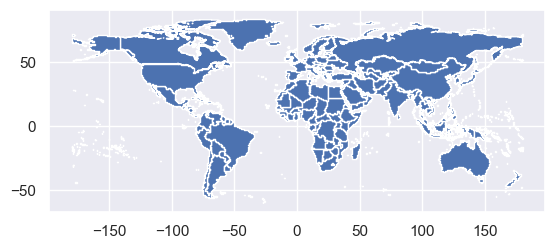

In [7]:
gdf.plot()


In [12]:
#get country mask
lon = population['lon']
lat = population['lat']
print(lat.shape)
mask = regionmask.mask_3D_geopandas(gdf,lon,lat)

(1117,)


/var/folders/r2/7vgy_x_x70gd4nm39slmcz640000gn/T/ipykernel_37129/3152620197.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap = cm.get_cmap('Reds', 11)


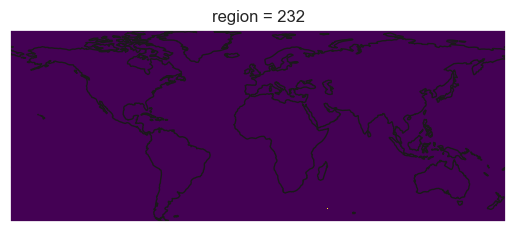

In [42]:
vmin = 0.
vmax = 4e6
my_cmap = cm.get_cmap('Reds', 11)
levels = np.linspace(vmin, vmax, 11)
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.sel(region=232).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ax.coastlines(color="0.1");

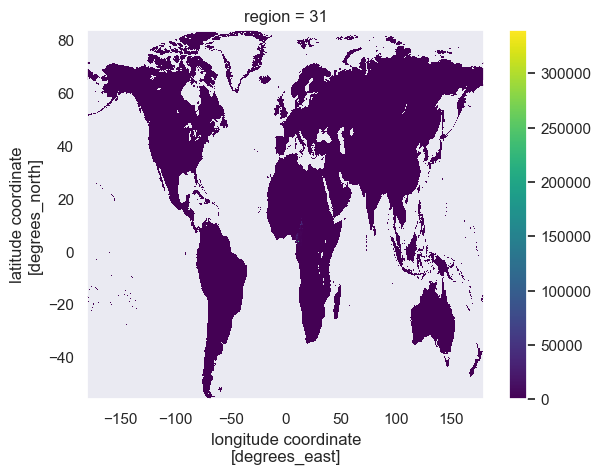

In [33]:
# to get population data to match with corresponding region
(mask.sel(region=31)* population['ssp2_2010']).plot()

In [31]:
population['ssp2_2010']

<xarray.DataArray 'ssp2_2010' (lat: 1117, lon: 2880)> Size: 26MB
dask.array<open_dataset-ssp2_2010, shape=(1117, 2880), dtype=float64, chunksize=(1117, 2880), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 23kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 9kB 83.69 83.56 83.44 83.31 ... -55.56 -55.69 -55.81
Attributes:
    long_name:       ssp2_2010
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree